In [68]:
#from pycocotools.coco import COCO
import os
import random
import shutil
import requests
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as tvt
import torch.nn as nn
import torch
import io
import numpy as np
from skimage import io, color
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import copy
import seaborn as sns
import io
from torchvision.utils import make_grid
from imageio import imread
import cv2
from chitra.image import Chitra
import chitra
import json
import torchvision.ops.ciou_loss as ciou
import torchvision
from sklearn.metrics import accuracy_score
random.seed(1000)

SyntaxError: invalid syntax (__init__.py, line 95)

In [62]:
!pip install pycoco

  Using cached pycoco-0.7.2.zip (14 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/573.4 kB ? eta -:--:--
     ---------------------- --------------- 337.9/573.4 kB 7.0 MB/s eta 0:00:01
     -------------------------------------- 573.4/573.4 kB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/399.7 kB ? eta -:--:--
     ------------------------------------- 399.7/399.7 kB 12.6 MB/s eta 0:00:00
  Created wheel for pycoco: filename=pycoco-0.7.2-py3-none-any.whl size=9793 sha256=850dc2c18ebf87fdfbe9464d0c517ffd578371a9f14a966dac62800bd7c444bb
  Stored in directory: c:\users\asoka\appdata\local\pip\cache\wheels\da\eb\b6\5c1636dfaf803b29e926a54c93b4ae04ea8038aca7bf3e55d9
Successfully built pycoco


In [2]:
class DataDownloader():
    
    def __init__(self, ann_file="",class_list=[], num_images_class= int, json_path = '', json_filename = ''):
        #self.image_root= image_root              #To access the folder containing images
        self.ann_file= COCO(ann_file)            # Using COCO to read the annotations file
        self.class_list= class_list              #User specified class labels that should be present in the Dataset
        self.num_images_class=num_images_class   #Number of images needed per class
        self.json_path = os.path.join(json_path, json_filename)
        
    
    def getImages(self, folder_name=""):
        if folder_name:
            os.mkdir(folder_name)
            direc=folder_name
        else:
            os.mkdir("New Folder") 
            direc = folder_name
            
        infoList=[] #Empty dictionary for storing image path and label
        new_ann_list = []
        for i, cat in enumerate(self.class_list):
            cat_root = direc + '/'+ cat
            os.mkdir(cat_root)
            
            catId = self.ann_file.getCatIds(catNms=cat)                                #getting the categories Ids from the list provided
            imgId= self.ann_file.getImgIds(catIds=catId)                               #getting images Ids for a single category
    
            imgDict= self.ann_file.loadImgs(imgId)                  #getting the list of dictionaries containing image infor such name, URL.
            #imgDict= self.ann_file.loadImgs(imgId)
            saveVal = 0
            for files in imgDict:
                
                new_ann = {}
                new_ann['file_name'] = files['file_name']
                new_ann['category'] = i
                req = requests.get(files["coco_url"], stream = True).raw
                #downImage = Image.open(requests.get(files["coco_url"], stream = True).raw)
                downImage = Image.open(io.BytesIO(req.read()))                #To prevent Unidentified image error
                annIds = self.ann_file.getAnnIds( imgIds = files['id'], catIds = catId , iscrowd = False )
                anns = self.ann_file.loadAnns(annIds)
                image = np.uint8(downImage)
                if saveVal > self.num_images_class:
                    break
                for ann in anns:
                    if ann['area'] >= 40000 and ann['area'] <= 50000:
                        [x , y , w , h] = ann['bbox']
                        bbox = ann['bbox']
                        image = cv2 . rectangle ( image , (int( x ) , int( y ) ) , (int( x + w ) ,int ( y + h ) ) , ( 36 , 255 , 12 ) , 2 )
                    
                        #image = Image.fromarray(image)
                        filename = os.path.join(cat_root, files['file_name'])
                        
                        #image.save(filename)
                        resize_tool = Chitra(image, bboxes = [x , y , w , h], labels= cat) #Chitra Library is used to resize the images along with bounding boxes    
                        resize_tool.resize_image_with_bbox((256, 256))
                        resize_tool.image.save(filename)
                        bbox_list = []
                        new_bbox = resize_tool.bboxes
                        xmin = new_bbox[0][0][0]
                        ymin = new_bbox[0][0][1]
                        xmax = new_bbox[0][1][0]
                        ymax = new_bbox[0][1][1]
                        bbox_list.append(tuple((xmin,ymin)))
                        bbox_list.append(tuple((xmax,ymax)))
                        new_ann['bbox'] = bbox_list                #saving the new bbo
                        saveVal += 1
                        new_ann['file_path'] = cat_root + '/' + files['file_name']
                    else:
                        bbox = None
                        break
                    new_ann_list.append(new_ann)
                    
                
            with open(self.json_path+".json", 'w') as file:
                json.dump(eval(str(new_ann_list)), file)                        #saving the annotations in json
                
                '''
                resize = downImage.resize((64,64))
                #resize.save(f"{direc}/{files['file_name']}")
                filename = os.path.join(cat_root, files['file_name'])

                resize.save(filename)
                '''
                #infoList[files['file_name']] = cat
                
                
                #os.system(f"wget -P {direc} -i {files['coco_url']}")
                infoList.append((files['file_name'], self.class_list.index(cat)))
                                
        return infoList

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, new_ann_file = "", transform = []):
        self.new_ann_file = new_ann_file
        if transform:
            self.transform=transform
        else:
            self.transform= [tvt.ToTensor()]
        
        with open(self.new_ann_file, 'r') as f:
            self.ann_dict = json.load(f)
        
    def __len__(self):
        return len(self.ann_dict)
    def __getitem__(self, index):
        
        imagePath = self.ann_dict[index]["file_path"]
        label = self.ann_dict[index]["category"]
        bbox = np.ndarray.flatten(np.array(self.ann_dict[index]["bbox"]))
        bbox = bbox.reshape(1,4)
        xmin = bbox[0][0] / 256
        ymin = bbox[0][1] /256
        xmax = bbox[0][2] / 256
        ymax = bbox[0][3] / 256
        bbox_array = np.array([xmin, ymin, xmax, ymax]).reshape(1,4)
        #print(bbox)
        nbbox = torch.tensor(bbox_array, dtype = torch.float)
        bbox_tensor = torch.tensor(bbox, dtype = torch.float)
        #bbox_tensor = torch.unsqueeze(bbox_tensor,1)
        #bbox_tensor = torch.unsqueeze(bbox_tensor,1)
        image = Image.open(imagePath).convert('RGB')
        
        tvtform = tvt.Compose(self.transform)
        augmentedImage = tvtform(image)
        return augmentedImage , label, nbbox
        
        

In [69]:
download = DataDownloader(ann_file="D:/Desktop/Deep Learning/Homework 4/annotations_trainval2014/annotations/instances_val2014.json",
                          class_list=['bus','cat','pizza'], num_images_class=1334, json_path="D:/Desktop/Deep Learning/Homework 5"
                          ,json_filename= 'ann'
                         )


NameError: name 'COCO' is not defined

In [59]:
imgInfo = download.getImages(folder_name= "rough")

NameError: name 'download' is not defined

In [ ]:
dataset = CustomDataset(new_ann_file = "D:/Desktop/Deep Learning/Homework 5/ann.json")

In [ ]:
len(dataset)

In [4]:
#Resblock

class SachBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = False):
        super(SachBlock,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels= in_channels, out_channels= out_channels, kernel_size=2, stride=2, padding=1)
        self .bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size=3)
        self .bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size=3)
        self .bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample_op = nn.Conv2d(in_channels, out_channels, kernel_size=8, stride=2)
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample == True:
            identity = self.downsample_op(identity)
        
        out += identity
        out = self.relu(out)
        return out
        
        
        
            
    

In [5]:
#Resnet Architecture

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        #self.out_channels = 16
        '''Classfication'''
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3)
        self.block1 = SachBlock(in_channels=16, out_channels=32, downsample=True)
        self.block2 = SachBlock(in_channels=32, out_channels=32, downsample=True)
        self.block3 = SachBlock(in_channels=32, out_channels=32, downsample=True)
        self.blockr = SachBlock(in_channels=16, out_channels=32, downsample=True)
        self.blockr1 = SachBlock(in_channels= 32, out_channels=32, downsample= True)
        self.blockr3 = SachBlock(in_channels= 32, out_channels=32, downsample= True)
        self.fc1 = nn.Linear(12800,1000 )
        self.fc2 = nn.Linear(1000, 3, bias=True)
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.relu = nn.ReLU(inplace= True)
        '''Regression'''
        self.linear_sequence = nn.Sequential(nn.Linear(3872, 500),
                                             nn.ReLU(inplace=True ),
                                             nn.Linear(500, 4),
                                             
                                             )
        self .conv_Sequence = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True ), 
                                         nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1) ,  
                                           nn.ReLU(inplace=True ) , 
                                            self.blockr, self.blockr1
                                         
                                         )
                    
        
    def forward(self,x):
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x1 = self.block1(x1)
        x1 = self.block2(x1)
        x1 = self.block3(x1)
        x1 = self.avg_pool(x1)
        x1 = x1.view(x1.shape[0], -1)
        x1 = self.fc1(x1)
        x1 = self.relu(x1)
        x1 = self.fc2(x1)
        '''Regression'''
        x2 = x.clone()
        x2 = self.conv_Sequence(x2)
        x2 = x2.view(x2.shape[0], -1)
        x2 = self.linear_sequence(x2)
        
        
        
        
        return x1, x2
    
    
    

In [6]:

#This code is taken from previous solution

def run_code_for_training(net, train_loader, learning_rate=1e-5, momentum_set=0.9, epochs=7, device='cuda:0'):
    report_fre = 50 # 500
    net = net.to(device)
    criterion1 = nn.CrossEntropyLoss()
    criterion2 = nn.MSELoss()
    #criterion3 = torchvision.ops.complete_box_iou_loss()
    #criterion2 = nn.HuberLoss
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,momentum=momentum_set)
    loss_running_record_label = []
    loss_running_record_bbox = []
    loss_running_record_ciou = []
    Iter_record = []
    for epoch in range(epochs):
        running_loss_label = 0.0
        running_loss_bbox = 0.0
        running_loss_ciou = 0.0
        for i, data in enumerate(train_loader):
            # print(i)
            inputs, labels, bbox_gt = data
            bbox_gt = torch.squeeze(bbox_gt,1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            bbox_gt = bbox_gt.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            outputs_label = outputs[0]
            bbox_pred = outputs[1]
            #print("gt", bbox_gt)
            #print("pred",bbox_pred)

            loss_label = criterion1(outputs_label, labels)
            loss_label.backward(retain_graph=True )
            loss_regression = criterion2(bbox_pred, bbox_gt)
            #print(loss_regression)
            #loss_regression.backward()
            
            loss_ciou = torchvision.ops.complete_box_iou_loss(bbox_pred,bbox_gt, reduction='mean')
            loss_ciou.backward()

            optimizer.step()
            running_loss_label += loss_label.item()
            running_loss_bbox += loss_regression.item()
            running_loss_ciou += loss_ciou.item()
        # print(loss_label.item(), loss_regression.item())
            if (i + 1) % report_fre == 0:
                points1 = running_loss_label / float(report_fre)
                points2 = running_loss_bbox / float(report_fre)
                points3 = running_loss_ciou / float(report_fre)
                loss_running_record_label.append(points1)
                loss_running_record_bbox.append(points2)
                loss_running_record_ciou.append(points3)
                Iter_record.append(len(loss_running_record_label))
                print("\n[epoch:%d, batch:%5d] classification loss: %.3f,regression loss: %.3f" % (epoch + 1, i + 1, points1, points3))
                #print("ciou loss", points3)
                running_loss_label = 0.0
                running_loss_bbox = 0.0
                running_loss_ciou = 0.0
        net_path = './net.pth'
        torch.save(net.state_dict(), net_path)
        print('Finished Training')
    return loss_running_record_label, loss_running_record_ciou, Iter_record

In [7]:
trainingDataset = CustomDataset(new_ann_file = "D:/Desktop/Deep Learning/Homework 5/train.json")
train_data_loader = DataLoader(dataset = trainingDataset, num_workers = 0, batch_size=10, shuffle = True)

In [70]:
trainingDataset = CustomDataset(new_ann_file = "D:/Desktop/Deep Learning/Homework 5/ann.json")
train_data_loader = DataLoader(dataset = trainingDataset, num_workers = 0, batch_size=10, shuffle = True)

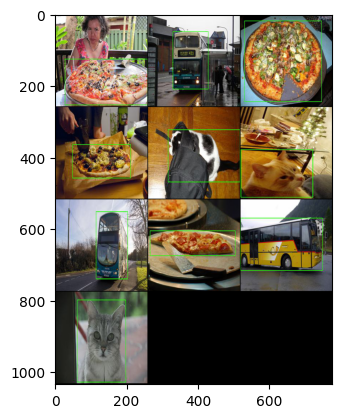

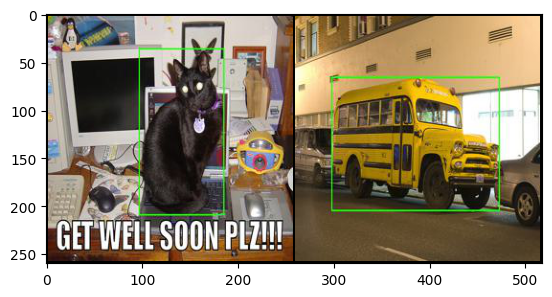

In [77]:
toPil=tvt.ToPILImage()
for im, label, j in train_data_loader :
    gridImage = make_grid(im, nrow=3)
    pilImage = toPil(gridImage)
    plt.imshow(pilImage)
    plt.show()

In [8]:

trainingDataset.__getitem__(1)[2]

tensor([[0.0015, 0.2050, 0.8927, 0.5708]])

In [11]:
net1 = Resnet()
task1 = run_code_for_training(net= net1, train_loader= train_data_loader, device='cuda')


[epoch:1, batch:   50] classification loss: 1.099,regression loss: 1.679

[epoch:1, batch:  100] classification loss: 1.083,regression loss: 1.484

[epoch:1, batch:  150] classification loss: 1.073,regression loss: 1.268

[epoch:1, batch:  200] classification loss: 1.044,regression loss: 1.181

[epoch:1, batch:  250] classification loss: 1.038,regression loss: 1.114

[epoch:1, batch:  300] classification loss: 1.014,regression loss: 1.103

[epoch:1, batch:  350] classification loss: 0.989,regression loss: 1.149
Finished Training

[epoch:2, batch:   50] classification loss: 0.955,regression loss: 1.091

[epoch:2, batch:  100] classification loss: 0.947,regression loss: 1.083

[epoch:2, batch:  150] classification loss: 0.914,regression loss: 1.091

[epoch:2, batch:  200] classification loss: 0.880,regression loss: 1.090

[epoch:2, batch:  250] classification loss: 0.865,regression loss: 1.082

[epoch:2, batch:  300] classification loss: 0.831,regression loss: 1.080

[epoch:2, batch:  3

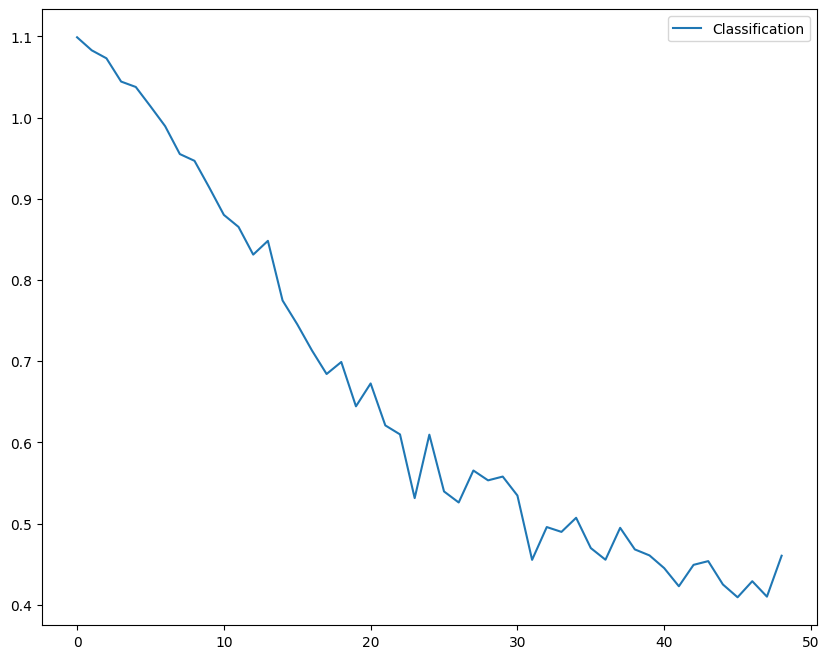

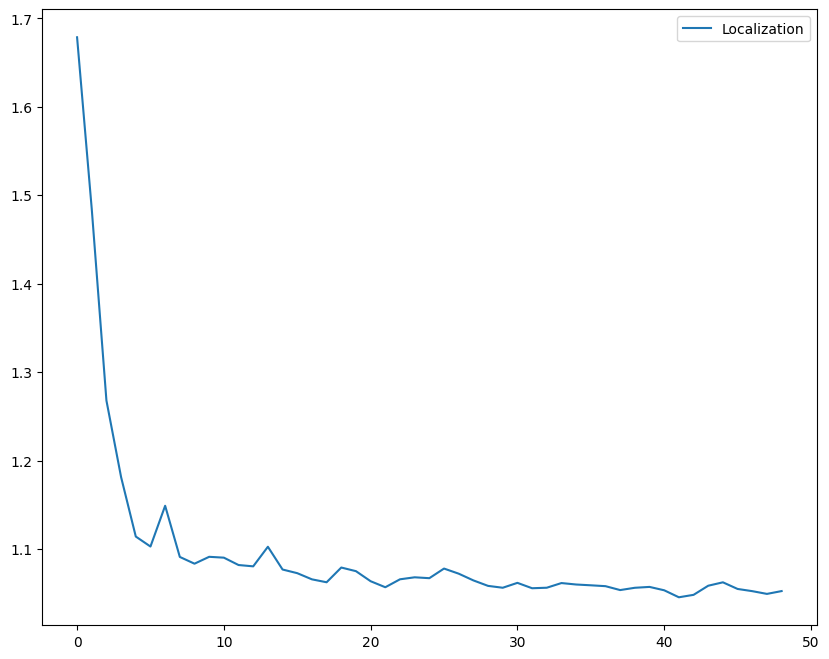

In [12]:
task1[1]
fig = plt.figure(figsize=(10, 8))
plt.plot(task1[0], label='Classification')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(task1[1], label='Localization')
plt.legend()
plt.show()


In [16]:
class ValCustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, new_ann_file = "", transform = []):
        self.new_ann_file = new_ann_file
        if transform:
            self.transform=transform
        else:
            self.transform= [tvt.ToTensor()]
        
        with open(self.new_ann_file, 'r') as f:
            self.ann_dict = json.load(f)
        
    def __len__(self):
        return len(self.ann_dict)
    def __getitem__(self, index):
        
        imagePath = self.ann_dict[index]["file_path"]
        label = self.ann_dict[index]["category"]
        bbox = np.ndarray.flatten(np.array(self.ann_dict[index]["bbox"]))
        bbox = bbox.reshape(1,4)
        xmin = bbox[0][0] / 256
        ymin = bbox[0][1] / 256
        xmax = bbox[0][2] / 256
        ymax = bbox[0][3] / 256
        bbox_array = np.array([xmin, ymin, xmax, ymax]).reshape(1,4)
        #print(bbox)
        nbbox = torch.tensor(bbox_array, dtype = torch.float)
        bbox_tensor = torch.tensor(bbox, dtype = torch.float)
        #bbox_tensor = torch.unsqueeze(bbox_tensor,1)
        #bbox_tensor = torch.unsqueeze(bbox_tensor,1)
        image = Image.open(imagePath).convert('RGB')
        
        tvtform = tvt.Compose(self.transform)
        augmentedImage = tvtform(image)
        return augmentedImage , label, nbbox, index

In [14]:
#validation
def validation(val_loader, net, mat_size, ann_file = "", json_path = "", updated_json_name = ""):           #Certain parts of the code is inspired from Previous year homework solutions
    with open(ann_file, 'r') as f:
             ann_dict = json.load(f)                                #Opening the ann file as it contains the index and image info
    new_json_path = os.path.join(json_path, updated_json_name)
    confusion_mat = np.zeros([mat_size, mat_size], dtype=int)        #which would be useful in accessing and including the pred box
    device = torch.device('cuda')
    net = copy.deepcopy(net)
    net = net.to(device)
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels, bbox_gt, image_index_list = data
            #print(image_index_list)
            inputs = inputs.to(device)
            labels = labels.to(device)
            bbox_gt = bbox_gt.to(device)
            outputs = net(inputs)
            outputs_label = outputs[0]
            bbox_pred = outputs[1]
            output_bb = bbox_pred.tolist()
            #print(output_bb)
            _, label_pred = torch.max(outputs[0], 1)
            for i, image_index in enumerate(image_index_list):               #predbbox contains the list of predboxes for each image corresponding to the list index of images
                ann_dict[image_index.item()]["pred_bbox"] = output_bb[i]


            accuracy = accuracy_score(labels.cpu(), label_pred.cpu().numpy())
            confusion_mat += confusion_matrix(labels.cpu().numpy(), label_pred.cpu().numpy(), labels=[0, 1, 2]) #Updating th confusion matrix for each batch of samples
    #print(ann_dict)
    with open(new_json_path+".json", 'w') as file:
        json.dump(eval(str(ann_dict)), file)
    print("Updated Json is available in directory")
    sns.heatmap(confusion_mat, xticklabels=['bus','cat', 'pizza'], yticklabels=['bus','cat', 'pizza'])
    return confusion_mat, accuracy

In [17]:
#Running Validation

valDataset = ValCustomDataset(new_ann_file = "D:/Desktop/Deep Learning/Homework 5/test.json")
val_Loader = DataLoader(dataset = valDataset, num_workers = 0, batch_size=10, shuffle = True)

In [76]:
valDataset.__getitem__(1)[3]

1

Updated Json is available in directory


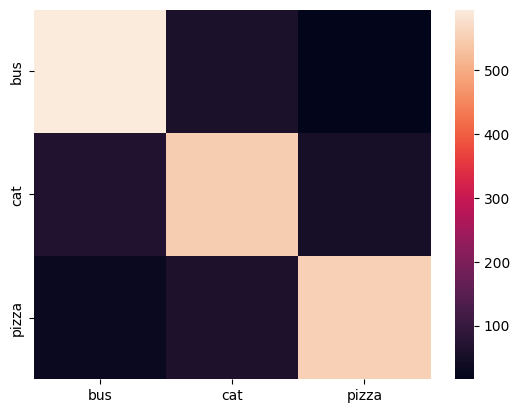

In [18]:
val = validation(val_loader= val_Loader, net= net1, mat_size= 3,ann_file="test.json", updated_json_name="val_ciou",
                 json_path="D:/Desktop/Deep Learning/Homework 5"
                )

In [20]:
print("The accuracy", val[1])

The accuracy 0.6666666666666666


In [51]:
def plot(image_info = "", r1 = int, r2 = int):   #specify the range of images of a certain class where you want to plot the bounding box for.
    with open(image_info, 'r') as f:
        image_info_dict = json.load(f)
    
    #for i in range(r1,r2):
    image = cv2.imread("D:/Desktop/Deep Learning/Homework 5/test/bus" + "/" + image_info_dict[r1]["file_name"])
    bbox = np.array(image_info_dict[r1]["bbox"]).reshape(4,1)
    #print(bbox.shape)
    pred_box = image_info_dict[r1]["pred_bbox"]
    x1 = int(pred_box[0]*256)
    y1 = int(pred_box[1]*256)
    x2 = int(pred_box[2]*256)
    y2 = int(pred_box[3]*256)
    new_pred = [x1, y1, x2, y2]

    cv2.rectangle(image, (x1,y1), (x2,y2), (255, 0, 0))
    cv2.rectangle(image, (int(bbox[0]),int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0))
    #cv2.imshow('Predicted Image', image)
    cv2.waitKey(1000) 

    plt.imshow(image)

        
    
    
    


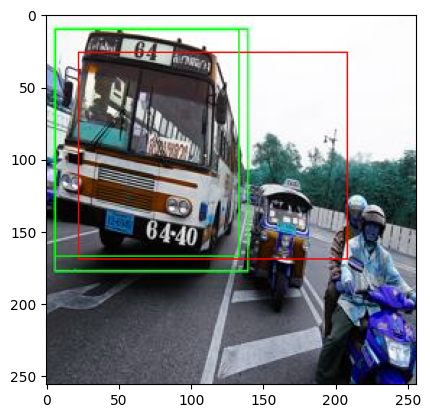

In [57]:
sach = plot(image_info="D:/Desktop/Deep Learning/Homework 5/val_ciou.json", r1 =145, r2= 704)
sach

In [5]:
with open("D:/Desktop/Deep Learning/Homework 5/ann.json", 'r') as f:
    ann_dict = json.load(f)

In [20]:
ann_dict[0]['']

[[38.584, 63.85544], [174.968, 139.2158]]

In [73]:
num_layers = len( list ( net1 . parameters () ) )
print(num_layers)

98


In [75]:
number_of_learnable_params = sum(p.numel() for p in net1.parameters() if p.requires_grad)

In [76]:
number_of_learnable_params

15206395